In [1]:
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy

from collections import defaultdict
from pdb import set_trace

%matplotlib inline

In [2]:
def load_optimal_q(path):
    with open(f'{path}/optimal_q.pkl', 'rb') as f:
        optimal_q = pickle.load(f)
    return optimal_q

def load_q_tables(path):
    with open(f'{path}/q_tables.pkl', 'rb') as f:
        q_tables = pickle.load(f)
    return q_tables

def load_train_config(path):
    with open(f'{path}/train_config.json') as f:
        train_config = json.load(f)
    return train_config

def load_eval_performance(path):
    with open(f'{path}/eval_performance.pkl', 'rb') as f:
        eval_performance = pickle.load(f)
    return eval_performance

def load_total_t(path):
    with open(f'{path}/total_t.pkl', 'rb') as f:
        total_t = pickle.load(f)
    return total_t

def load_info(path):
    with open(f'{path}/info.json') as f:
        info = json.load(f)
    return info

def load_p_tables(path):
    with open(f'{path}/p_tables.pkl', 'rb') as f:
        p_tables = pickle.load(f)
    return p_tables

In [3]:
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1, 1, 1)), (0, (3, 1, 1, 1))]

scheme_display_names = {
    'Self': 'Self',
    'Peers': 'Peers',
    'All': 'All',
    'Sampling': 'Sampling',
    'CAESAR': 'CAESAR',
    'Screen': 'Screen'
}

# functions for plotting q values of all agents
def set_y_lim(axs, ylow=-1.1, yhigh=1.1):
    custom_ylim = (ylow, yhigh)
    plt.setp(axs, ylim=custom_ylim)

def plot_agent(ax, env_id, q_tables, k, agent_id, state, action, color, training_steps, interval, total_ts=None, agent_styles={}):
    n_agents = len(q_tables)
    alpha_low_gap, alpha_high_gap = 5, 3
    x = np.arange(0, training_steps+1, interval)
    if total_ts is not None: x = [total_ts[u] for u in x]
    y = [q_tables[agent_id][t][state][action] for t in range(0, training_steps+1, interval)]
    linestyle = '-'
    if k in agent_styles:
        if 'color' in agent_styles[k]:
            color = agent_styles[k]['color']
        if 'linestyle' in agent_styles[k]:
            linestyle = agent_styles[k]['linestyle']
    ax.plot(x, y, color=color, alpha=(k+alpha_low_gap)/(n_agents+alpha_low_gap+alpha_high_gap), linestyle=linestyle, label=f"{env_id}-Agent{agent_id}")

def plot_q_values_mean_std(ax, env_id, q_tables, state, action, color, training_steps, interval, total_ts=None):
    n_agents = len(q_tables)
    q_values = []
    for agent_id in range(n_agents):
        agent_q_vals = [q_tables[agent_id][t][state][action] for t in range(0, training_steps+1, interval)]
        q_values.append(agent_q_vals)
    q_values_mean = np.mean(q_values, axis=0)
    q_values_std = np.std(q_values, axis=0)
    
    x = np.arange(0, training_steps+1, interval)
    if total_ts is not None: x = [total_ts[u] for u in x]
    y = q_values_mean
    
    ax.plot(x, y, color=color, label=f"{env_id}")
    ax.fill_between(x, (y-q_values_std), (y+q_values_std), color=color, alpha=.1)
        
def plot_q_values_for_env(ax, env_id, q_tables, optimal_q, state, action, color, training_steps, interval, mode="full", total_ts=None, display_states=None, agent_styles={}):
    if optimal_q is not None:
        optimal_q_val = optimal_q[state][action]
        ax.hlines(y=optimal_q_val, xmin=0, xmax=training_steps, color='k', linewidth=2., linestyle=':')
    if mode == "full":
        for k, agent_id in enumerate(q_tables.keys()):
            plot_agent(ax, env_id, q_tables, k, agent_id, state, action, color, training_steps, interval, total_ts, agent_styles)
    elif mode == "reduced":
        plot_q_values_mean_std(ax, env_id, q_tables, state, action, color, training_steps, interval, total_ts)
#     ax.title.set_text(f"State: {state if display_states is None else display_states[state]} Action: {action} ({'left' if action==0 else 'right'})")
    ax.title.set_text(f"State: {state if display_states is None else display_states[state]}, Action: {action}")
    ax.set_xlabel('Time steps') 
    ax.set_ylabel('Q-estimates')
    
def plot_q_values_dynamic(path, mode="full", plot_total_t=False, display_states=None, state_actions=None, figsize=(12,45), legend_y=-.1, title_y=0.91, custom_title=None, skip_envs=[], show_legend=True, agent_styles={}):
    train_config = load_train_config(path)
    training_steps = train_config['training_steps']
    interval = train_config['log_interval']
    info = load_info(path.rsplit('/',1)[0])
    state_space = info['observation_space']
    action_space = info['action_space']
    
    def get_ax(axs, loc):
        if isinstance(axs, np.ndarray):
            ax = axs[loc[0],loc[1]] if axs.ndim > 1 else axs[loc[1]]
        else:
            ax = axs
        return ax
    
    if state_actions is None:
        state_actions = [[(i,j) for j in action_space] for i in state_space]
    
    fig, axs = plt.subplots(len(state_actions),len(state_actions[0]), sharex=True, sharey=True, figsize=figsize)
    fig.set_dpi(500)

    optimal_q = load_optimal_q(path)
    q_tables = load_q_tables(path)
    total_ts = None if not plot_total_t else load_total_t(path)
    for i, (env_id, env_data) in enumerate(q_tables.items()):
        if env_id in skip_envs:
            continue
        color = f'C{i}'
        for row in range(len(state_actions)):
            for col in range(len(state_actions[0])):
                env_optimal_q = None if not optimal_q else optimal_q[env_id] # check if optimal q is empty
                plot_q_values_for_env(get_ax(axs, (row, col)), env_id, q_tables[env_id], env_optimal_q, state_actions[row][col][0], state_actions[row][col][1], color, training_steps, interval, mode, total_ts, display_states, agent_styles=agent_styles)
                
    handles, labels = get_ax(axs, (0, 0)).get_legend_handles_labels()
    if show_legend: 
        fig.legend(handles, labels, loc=('upper center'), bbox_to_anchor=(0,legend_y,1,1), ncol=10)
    title = f"Q-values for each state-action pairs (Scheme: {train_config['scheme']})"
    fig.suptitle(title if custom_title is None else custom_title, y=title_y)
    set_y_lim(axs)
    plt.tight_layout()
    plt.show()

def plot_q_values(path, mode="full", plot_total_t=False, display_states=None, show_legend=True):
    
    train_config = load_train_config(path)
    training_steps = train_config['training_steps']
    interval = train_config['log_interval']
    info = load_info(path.rsplit('/',1)[0])
    state_space = info['observation_space']
    action_space = info['action_space']
    
    def get_ax(axs, loc):
        if isinstance(axs, np.ndarray):
            ax = axs[loc[0],loc[1]] if axs.ndim > 1 else axs[loc[1]]
        else:
            ax = axs
        return ax
    
    fig, axs = plt.subplots(len(state_space),len(action_space), figsize=(10,45))
    fig.set_dpi(500)

    optimal_q = load_optimal_q(path)
    q_tables = load_q_tables(path)
    total_ts = None if not plot_total_t else load_total_t(path)
    for i, (env_id, env_data) in enumerate(q_tables.items()):
        color = f'C{i}'
        for state in state_space:
            for action in action_space:
                env_optimal_q = None if not optimal_q else optimal_q[env_id] # check if optimal q is empty
                plot_q_values_for_env(get_ax(axs, (state, action)), env_id, q_tables[env_id], env_optimal_q, state, action, color, training_steps, interval, mode, total_ts, display_states)
        
    handles, labels = axs[0,0].get_legend_handles_labels()
    if show_legend:
        fig.legend(handles, labels, loc=('upper center'), bbox_to_anchor=(0,-0.1,1,1), ncol=10)
    title = f"Q-values for each state-action pairs (Scheme: {train_config['scheme']})"
    fig.suptitle(title, y=0.91)
    set_y_lim(axs)
    plt.show()
    
# functions for plotting q errors
def plot_q_error_for_env(axs, loc, train_config, env_id, q_tables, optimal_q, state, action, color, training_steps, interval, linestyle, total_ts=None):
    ax = axs[loc[0],loc[1]] if isinstance(axs, np.ndarray) else axs
    optimal_q_val = optimal_q[state][action]
    errors = []
    for agent_id in range(len(q_tables)):
        agent_error = np.abs(np.array([q_tables[agent_id][t][state][action] for t in range(0, training_steps+1, interval)]) - optimal_q_val)
        errors.append(agent_error)
    errors_mean = np.mean(errors, axis=0)
    
    y = errors_mean
    x = np.arange(0, training_steps+1, interval)
    if total_ts is not None: x = [total_ts[u] for u in x]
    errors_std = np.std(errors, axis=0)
    
    ax.plot(x, y, color=color, label=f"{env_id}-{train_config['scheme']}", linestyle=linestyle)
    ax.fill_between(x, (y-errors_std), (y+errors_std), color=color, alpha=.1)
    
    ax.title.set_text(f"State: {state} Action: {action} ({'left' if action==0 else 'right'})")
    ax.set_xlabel('Time steps') 
    ax.set_ylabel('Q-estimates')

def plot_q_errors(path, single_exp=True, linestyle='-', fig=None, axs=None, total_ts=None):
    
    train_config = load_train_config(path)
    training_steps = train_config['training_steps']
    interval = train_config['log_interval']
    exp_name = train_config['scheme']
    
    if single_exp:
        fig, axs = plt.subplots(9,2, figsize=(10,45))
        fig.set_dpi(500)
    
    optimal_q = load_optimal_q(path)
    q_tables = load_q_tables(path)
    for i, (env_id, env_data) in enumerate(q_tables.items()):
        color = f'C{i}'
        for state in range(-4,5):
            for action in range(0,2):
                plot_q_error_for_env(axs, (state+4, action), train_config, env_id, q_tables[env_id], optimal_q[env_id], state, action, color, training_steps, interval, linestyle, total_ts)
     
    if single_exp:
        handles, labels = axs[0,0].get_legend_handles_labels()
        fig.legend(handles, labels, loc=('upper center'), bbox_to_anchor=(0,-0.1,1,1), ncol=10)
        set_y_lim(axs)
        plt.show()

def plot_q_errors_across_exps(paths, plot_total_t=False):
    
#     linestyles = ['-', '--', ':', '-.']
    
    fig, axs = plt.subplots(9,2, figsize=(10,45))
    fig.set_dpi(500)
    title = f"Q-errors with different federation schemes"
    fig.suptitle(title, y=0.91)
    
    for i, path in enumerate(paths):
        total_ts = None if not plot_total_t else load_total_t(path)
        plot_q_errors(path, single_exp=False, linestyle=linestyles[i], fig=fig, axs=axs, total_ts=total_ts)
    
    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc=('upper center'), bbox_to_anchor=(0,-0.1,1,1), ncol=10)
    set_y_lim(axs)
    plt.show()
    
def get_eval_performance_data(path, env_id, plot_total_t=False, clip=None):
    train_config = load_train_config(path)
    training_steps = train_config['training_steps']
    interval = train_config['log_interval']
    exp_name = train_config['scheme']
    eval_performance = load_eval_performance(path)
    total_ts = None if not plot_total_t else load_total_t(path)
    x = np.arange(0, training_steps+1, interval)
    if total_ts is not None: x = [total_ts[u] for u in x]
    y = [eval_performance[env_id][t] for t in range(0, training_steps+1, interval)]
    if clip is not None:
        x = [t for t in x if t <= clip]
        y = y[:len(x)]
    return exp_name, x, y
    
def plot_eval_performance(paths, plot_total_t=False, clip=None):
    
    fig, ax = plt.subplots()
    ax.set_title('Performance')
    
    env_ids = load_train_config(paths[0])['env_ids']
    for i, env_id in enumerate(env_ids):
        for j, path in enumerate(paths):
            exp_name, x, y = get_eval_performance_data(path, env_id, plot_total_t, clip=clip)
            ax.plot(x, y, label=f'{env_id}-{exp_name}', color=f'C{j}', linestyle=linestyles[i])
    ax.legend()
    plt.show()

def compute_ci_alpha(li, ci=0.95):
    data = np.array(li)
    alphas = []
    for j in range(data.shape[1]):
        col = data[:,j]
        low, high = st.t.interval(confidence=ci, df=len(col)-1,
              loc=np.mean(col),
              scale=st.sem(col))
        if np.isnan(low):
            alphas.append(0.)
        else:
            alphas.append(np.mean(col) - low)
    return np.array(alphas)

def plot_eval_performance_over_seeds(
        dir_path, 
        seeds=np.arange(10), 
        plot_total_t=False,
        std=None,
        fig_path=None,
        clip=None,
        skip=None,
        split_envs=True,
        only_envs = None,
        ylims=(-.1,1.1),
        custom_title=None,
        figsize=[4,3]):
    
    nested_dict = lambda: defaultdict(nested_dict)
    data = nested_dict()
    info = load_info(f'{dir_path}/seed{seeds[0]}')
    schemes = info['schemes']
    env_ids = only_envs if only_envs else load_train_config(f'{dir_path}/seed{seeds[0]}/{schemes[0]}')['env_ids']
    
    fig, ax = plt.subplots(figsize=figsize)
    fig.set_dpi(500)
    if custom_title is not None:
#         title = f"{info['env']}: Agents' average performance"
#         ax.set_title(title)
        title = custom_title
        ax.set_title(title)
        
    ax.set_ylim(ylims[0], ylims[1])
    
    for seed in seeds:
        seed_path = f'{dir_path}/seed{seed}'
        for i, env_id in enumerate(env_ids):
            for scheme in schemes:
                path = f'{seed_path}/{scheme}'
                exp_name, x, y = get_eval_performance_data(path, env_id, plot_total_t, clip=clip)
                data[env_id][scheme][seed] = {'x': x, 'y': y}
    
    if split_envs:
        for i, env_id in enumerate(env_ids):
            for j, scheme in enumerate(schemes):
                if skip is not None and scheme in skip: continue
                xs = [data[env_id][scheme][seed]['x'] for seed in seeds]
                ys = [data[env_id][scheme][seed]['y'] for seed in seeds]
                x = xs[0]
                y = np.mean(ys, axis=0)
                y_std = compute_ci_alpha(ys, ci=0.95)
                color = f'C{j}'
                ax.plot(x, y, label=f'{env_id}-{scheme}', color=color, linestyle=linestyles[i])
                if std: ax.fill_between(x, (y-y_std), (y+y_std), color=color, alpha=.1)
    else:
        x = data[env_ids[0]][schemes[0]][seeds[0]]['x']
        for j, scheme in enumerate(schemes):
            ys = []
            for i, env_id in enumerate(env_ids):
                for seed in seeds:
                    ys.append(data[env_id][scheme][seed]['y'])
            y = np.mean(ys, axis=0)
            y_std = compute_ci_alpha(ys, ci=0.95)
            color = f'C{j}'
            ax.plot(x, y, label=f'{scheme_display_names[scheme]}', color=color)
            if std is not None: ax.fill_between(x, (y-std*y_std), (y+std*y_std), color=color, alpha=.1)
                
#     ax.legend(fontsize = 'medium', bbox_to_anchor=(1.05, 1.05))
    ax.legend(fontsize = 'small', loc='lower right')
    ax.set_ylabel("Average performance")
    ax.set_xlabel(f"{'total' if plot_total_t else ''} Training steps (per agent)")
    plt.grid()
    plt.show()
    
    if fig_path is not None:
        fig.savefig(f"../figure/{fig_path}")
        
def plot_p_table(ax, p_tables, t):
    ticks = np.arange(0, p_tables[0].shape[0])
    ax.imshow(p_tables[t], vmin = 0, vmax = 1, interpolation='nearest')
    ax.title.set_text(f't = {t}')
    ax.title.set_size(24)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.xaxis.tick_top()
    ax.tick_params(axis='x',labelrotation=90, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
        
def plot_p_tables(path, t=None, fig_path=None):
    p_tables = load_p_tables(path)
    train_config = load_train_config(path)
    training_steps = train_config['training_steps']
    interval = train_config['log_interval']
    
    if t is None:
        fig, axs = plt.subplots(1,6, figsize=(40,6))
        fig.set_dpi(500)
#         fig.suptitle('Prob. of i selecting j at timestep t')
        for i, t in enumerate(np.arange(0, training_steps+1, 2000)):
            plot_p_table(axs[i], p_tables, t)
    else:
        fig, ax = plt.subplots()
        fig.set_dpi(500)
        fig.suptitle(f'Prob. of i selecting j at timestep {t}')
        plot_p_table(ax, p_tables, t)
        ax.title.set_text('')
    
    if fig_path is not None:
        fig.savefig(f"../figure/{fig_path}") 


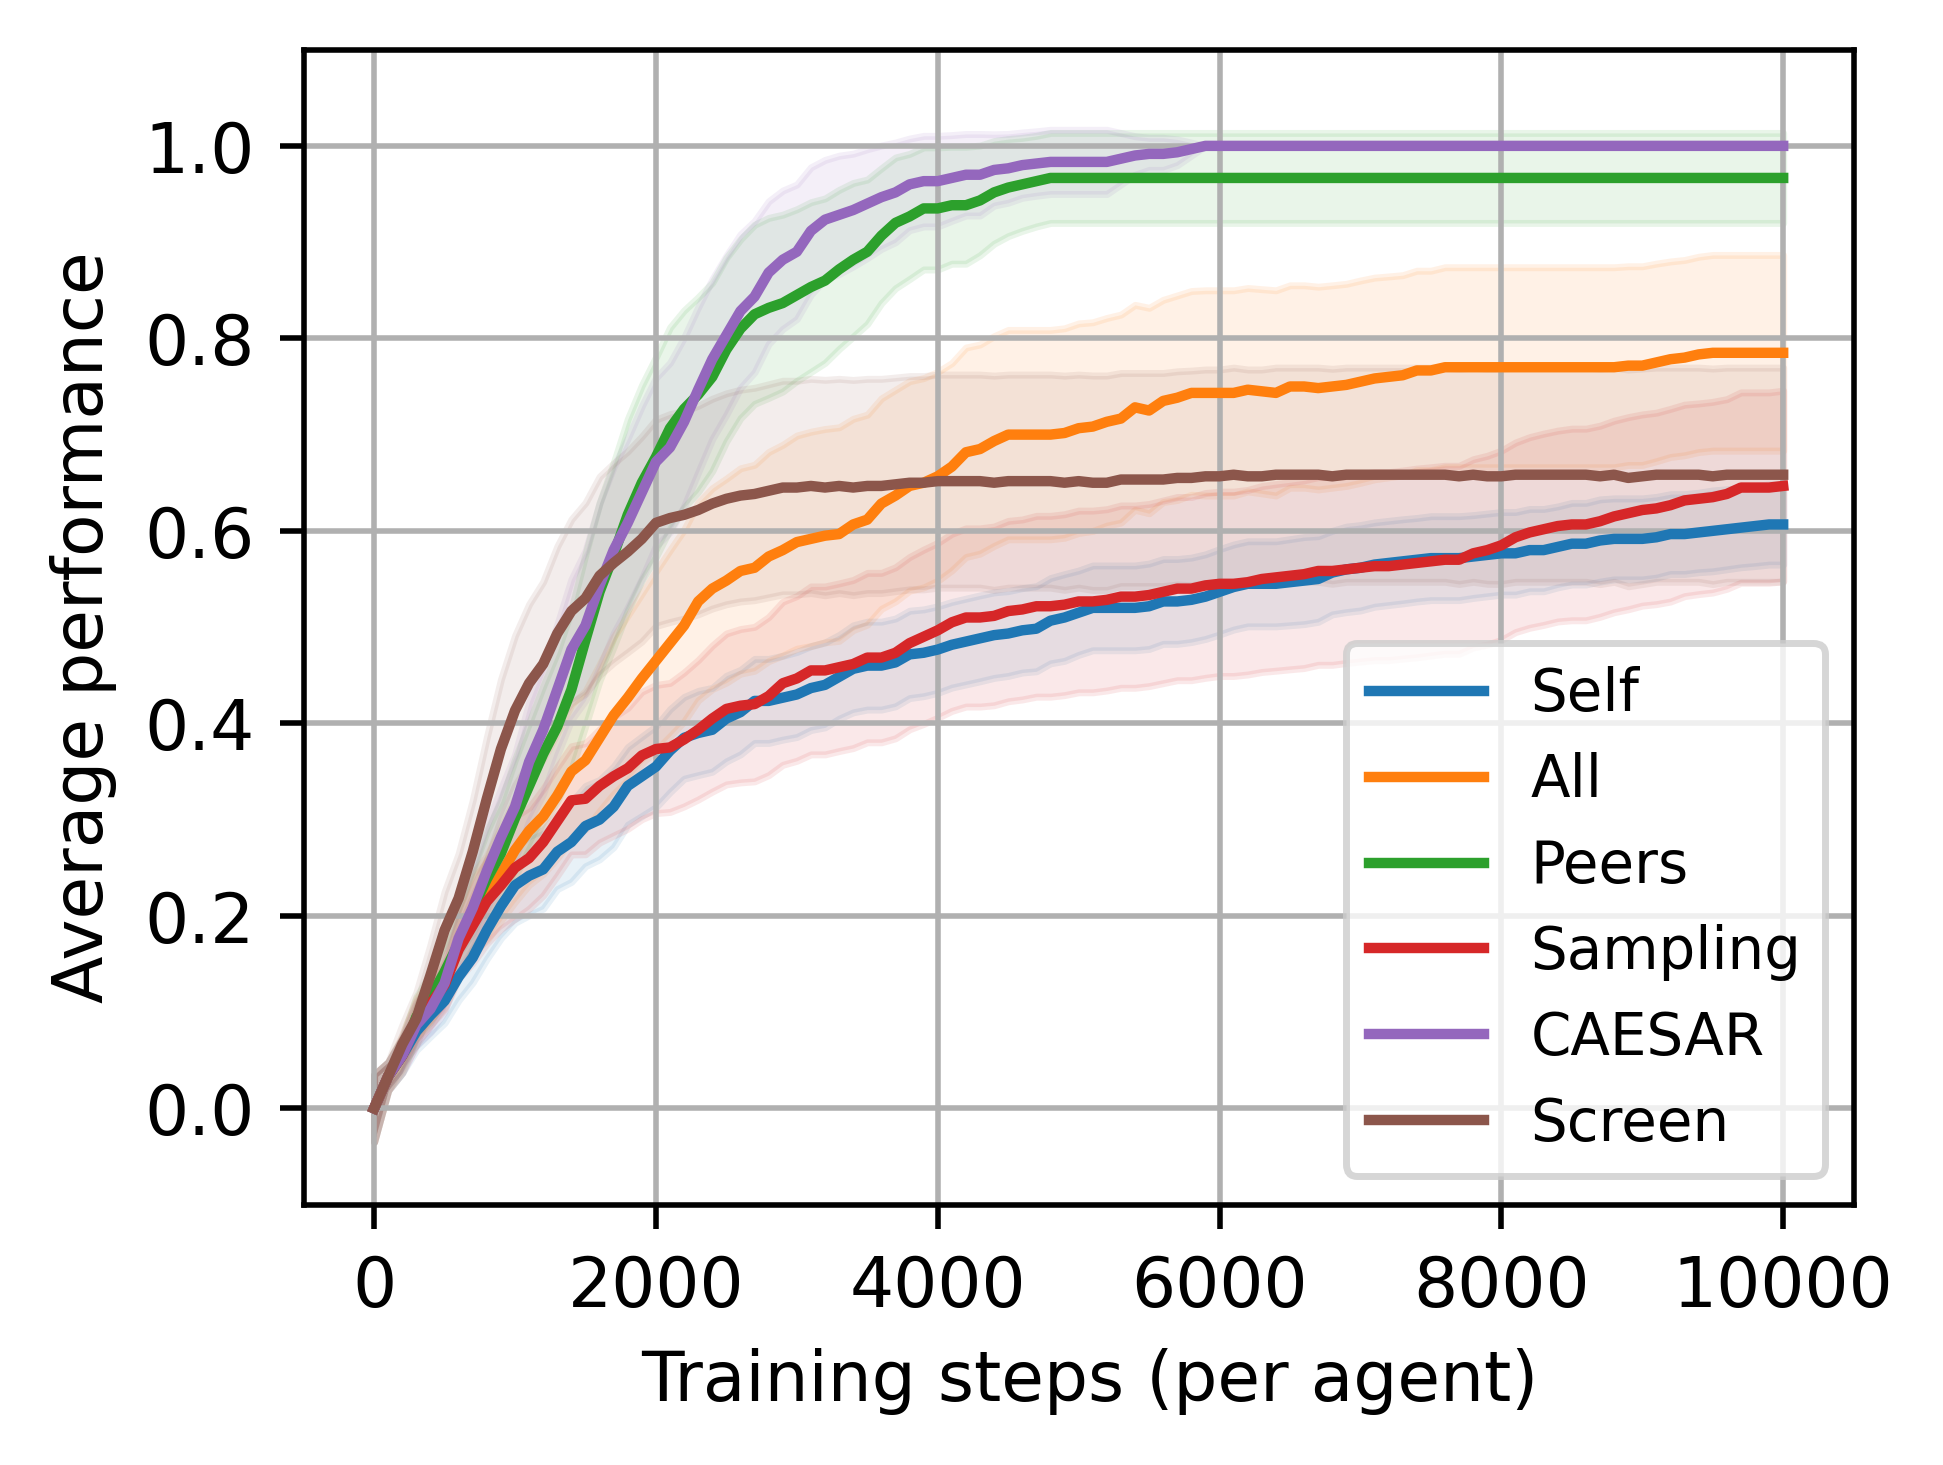

In [6]:
# Fig 6
dir_path = '../result/GridWorld/default/mu0.0/sig1.0/eps0.1/fedi100/feds1/init_p0.0/p_interval100/delta0.1/xi0.0001/p_reset0'
plot_eval_performance_over_seeds(dir_path, split_envs=False, std=1.0, seeds=range(30), custom_title='', figsize=[4,3])

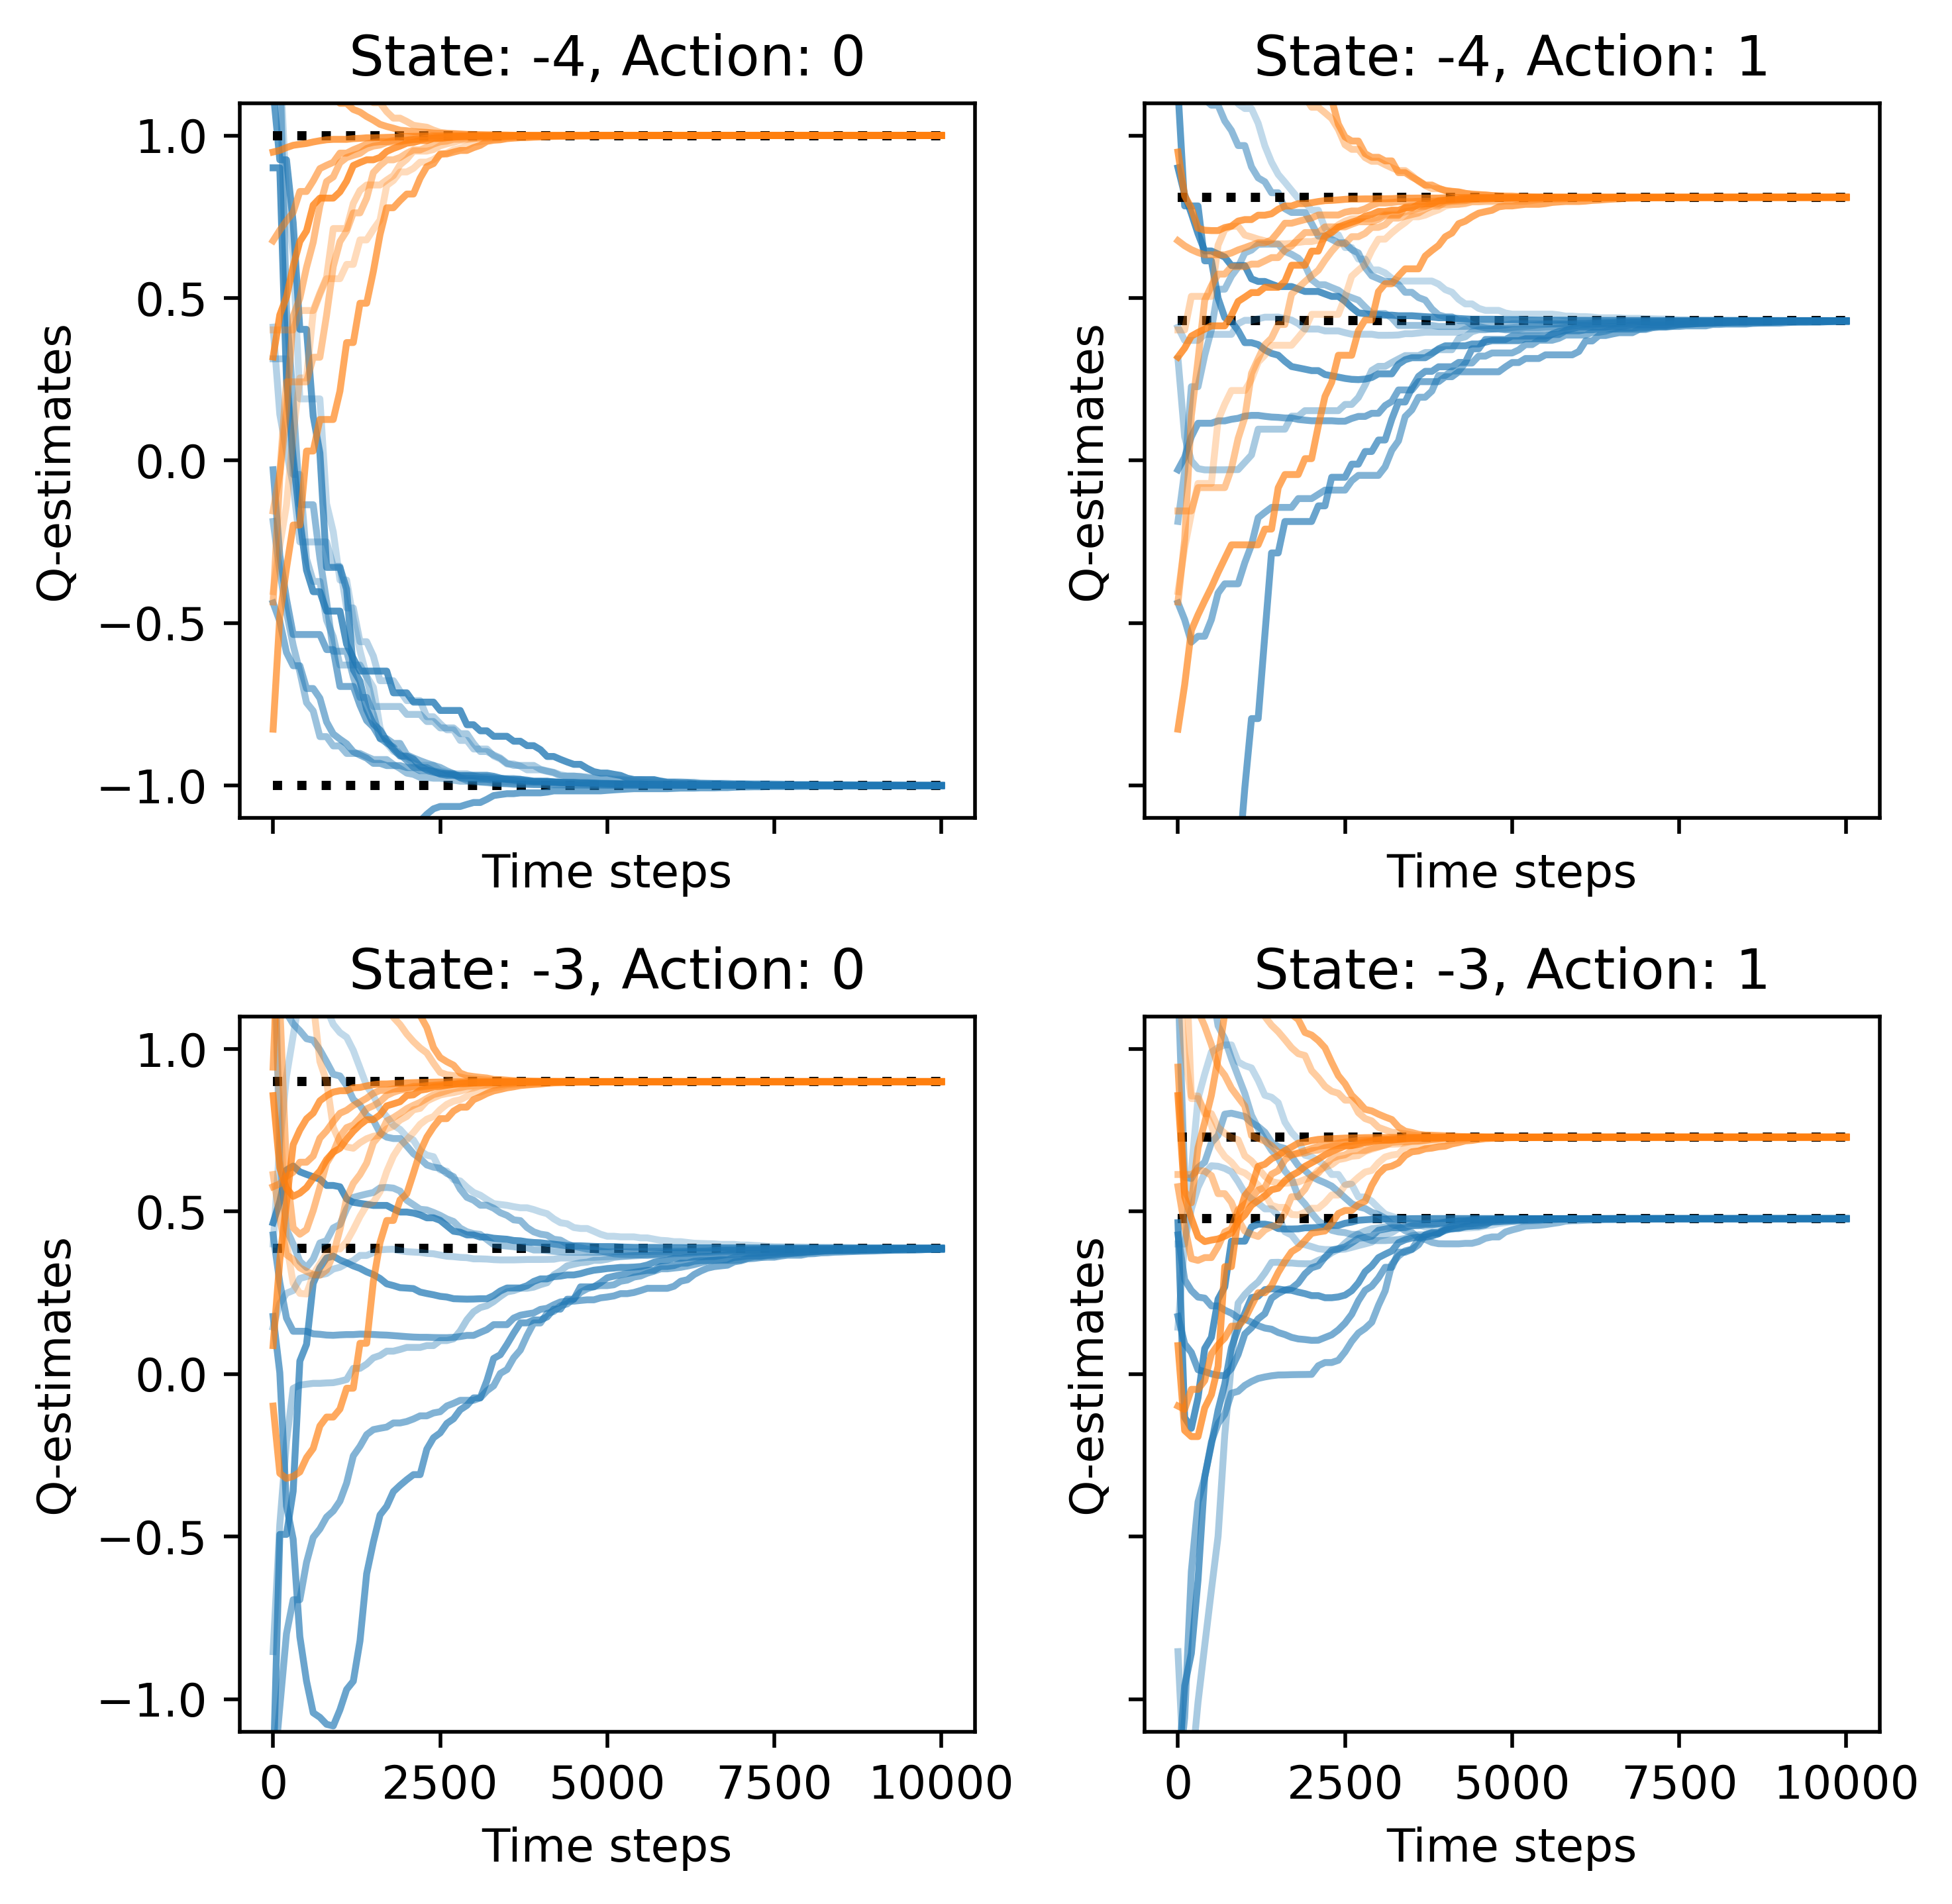

In [11]:
# Fig 5
dir_path = '../result/GridWorld/default/mu0.0/sig1.0/eps0.9/fedi100/feds1/init_p0.0/p_interval100/delta0.1/xi0.0001/p_reset0'
seed = 0
path = f'{dir_path}/seed{seed}/Self'
plot_q_values_dynamic(path, display_states=range(-4,5), state_actions=[[(0,0), (0,1)], [(1,0), (1,1)]], figsize=(6,6), legend_y=0.05, title_y=1.0, custom_title='', show_legend=False)

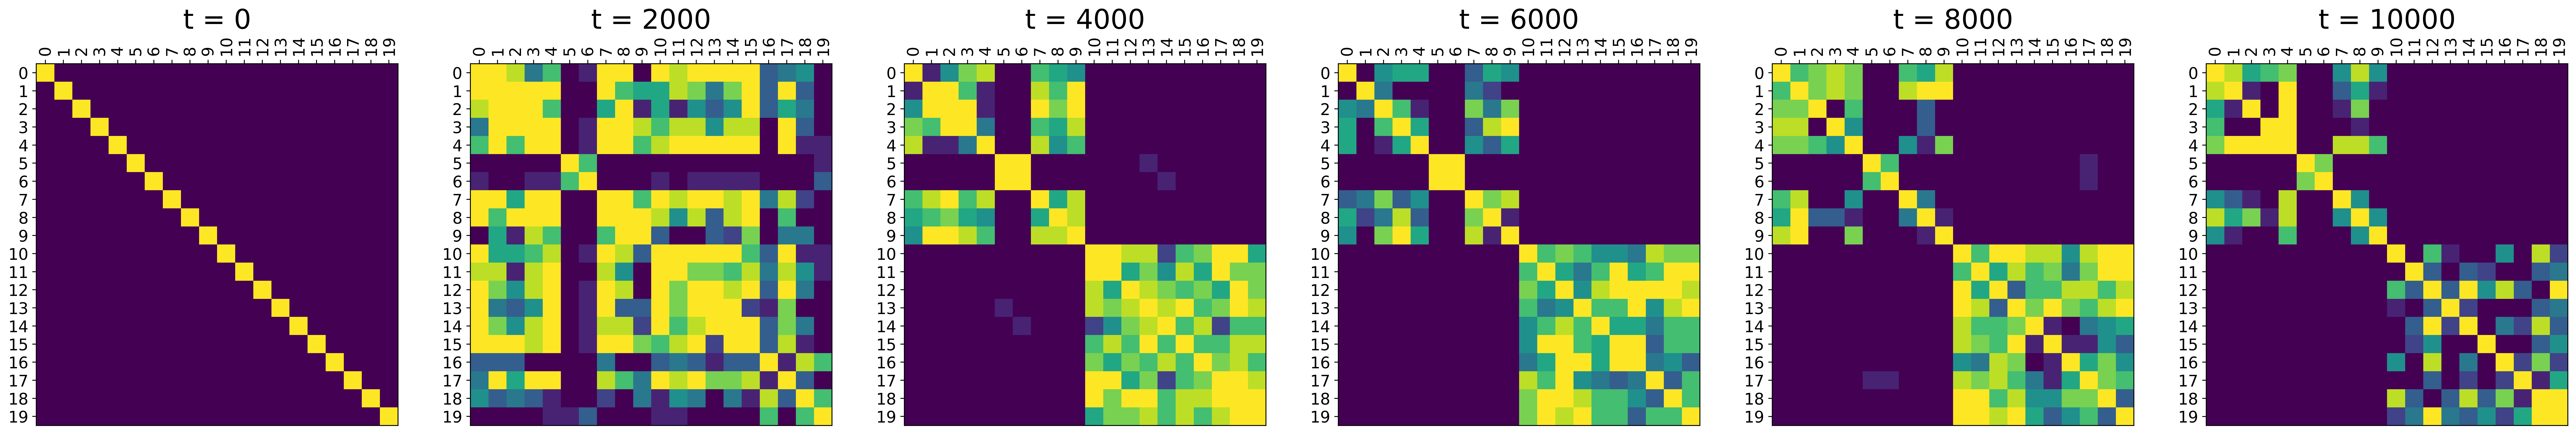

In [14]:
# Fig 7
dir_path = '../result/GridWorld/default/mu0.0/sig1.0/eps0.1/fedi100/feds1/init_p0.0/p_interval100/delta0.1/xi0.0001/p_reset0'
seed = 3
path = f'{dir_path}/seed{seed}/Sampling'
plot_p_tables(path, fig_path=None)

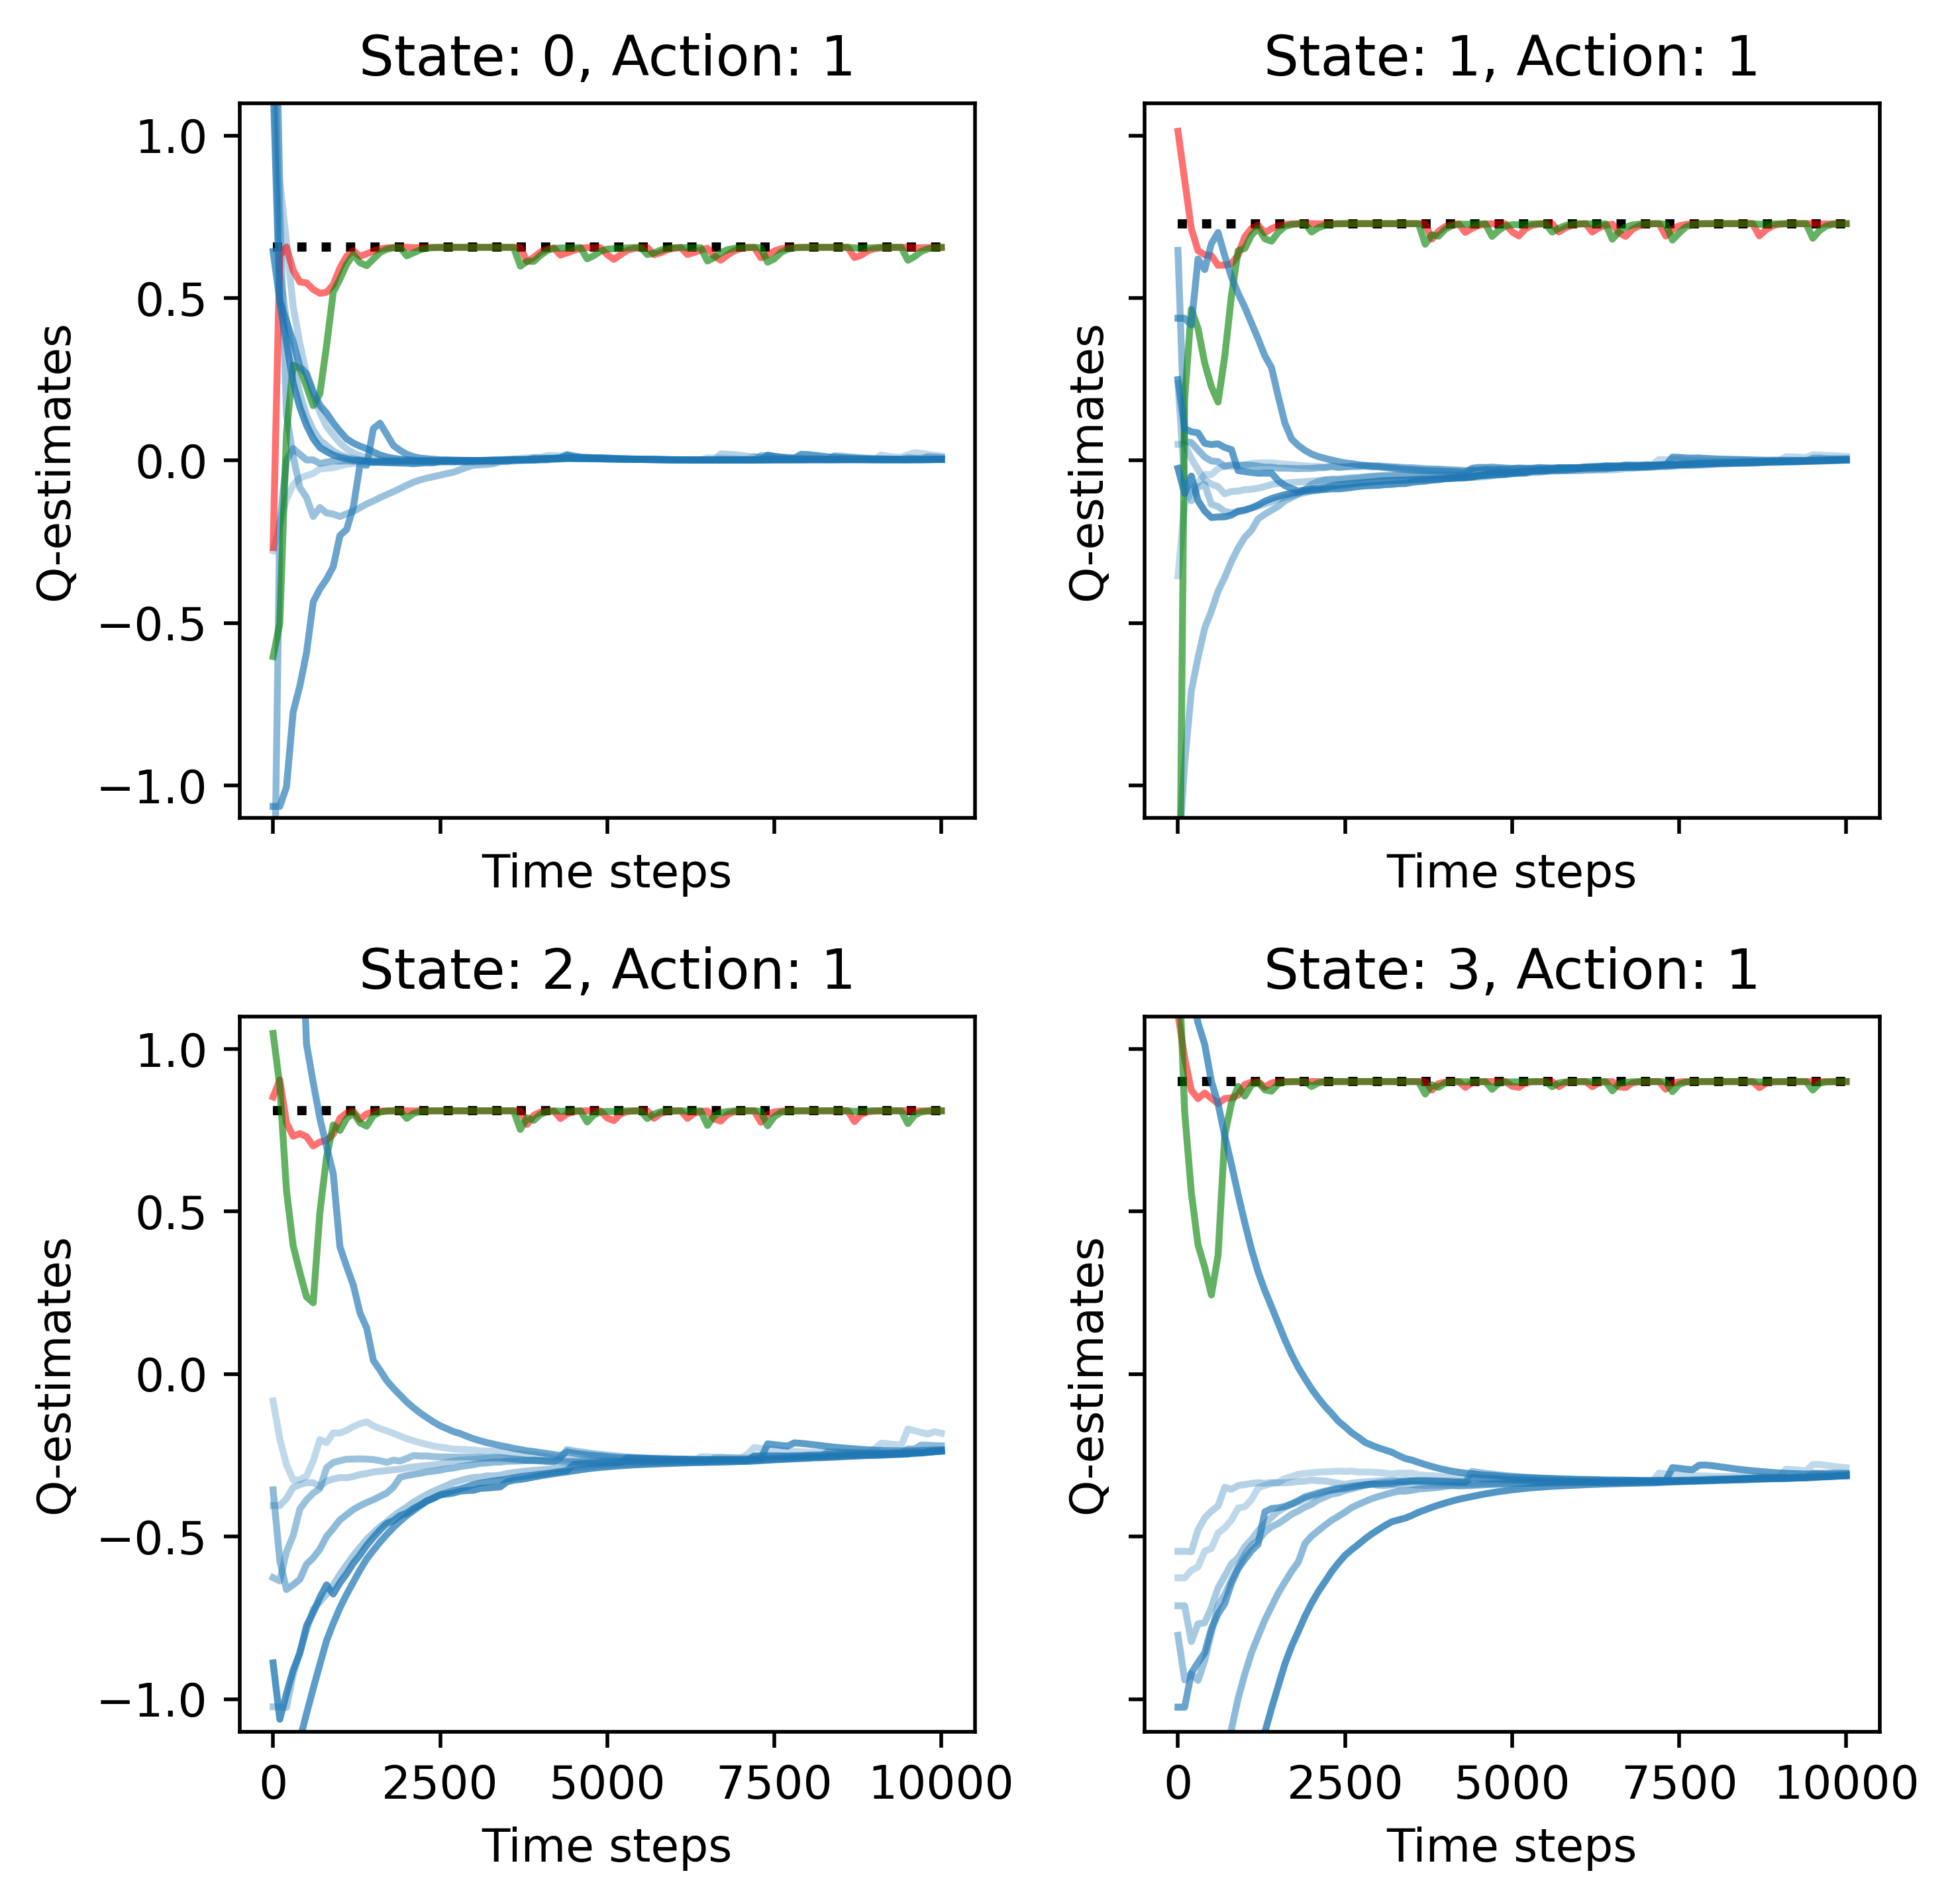

In [27]:
# Fig 8
dir_path = '../result/GridWorld/default/mu0.0/sig1.0/eps0.1/fedi100/feds1/init_p0.0/p_interval100/delta0.1/xi0.0001/p_reset0'
seed = 3
path = f'{dir_path}/seed{seed}/Sampling'
plot_q_values_dynamic(path, display_states=range(-4,5), state_actions=[[(4,1),(5,1)], [(6,1),(7,1)]], figsize=(6, 6), legend_y=0.1, title_y=1.0, custom_title='', skip_envs=['M2'], show_legend=False, agent_styles={5: {'color': 'red'}, 6: {'color': 'green'}})

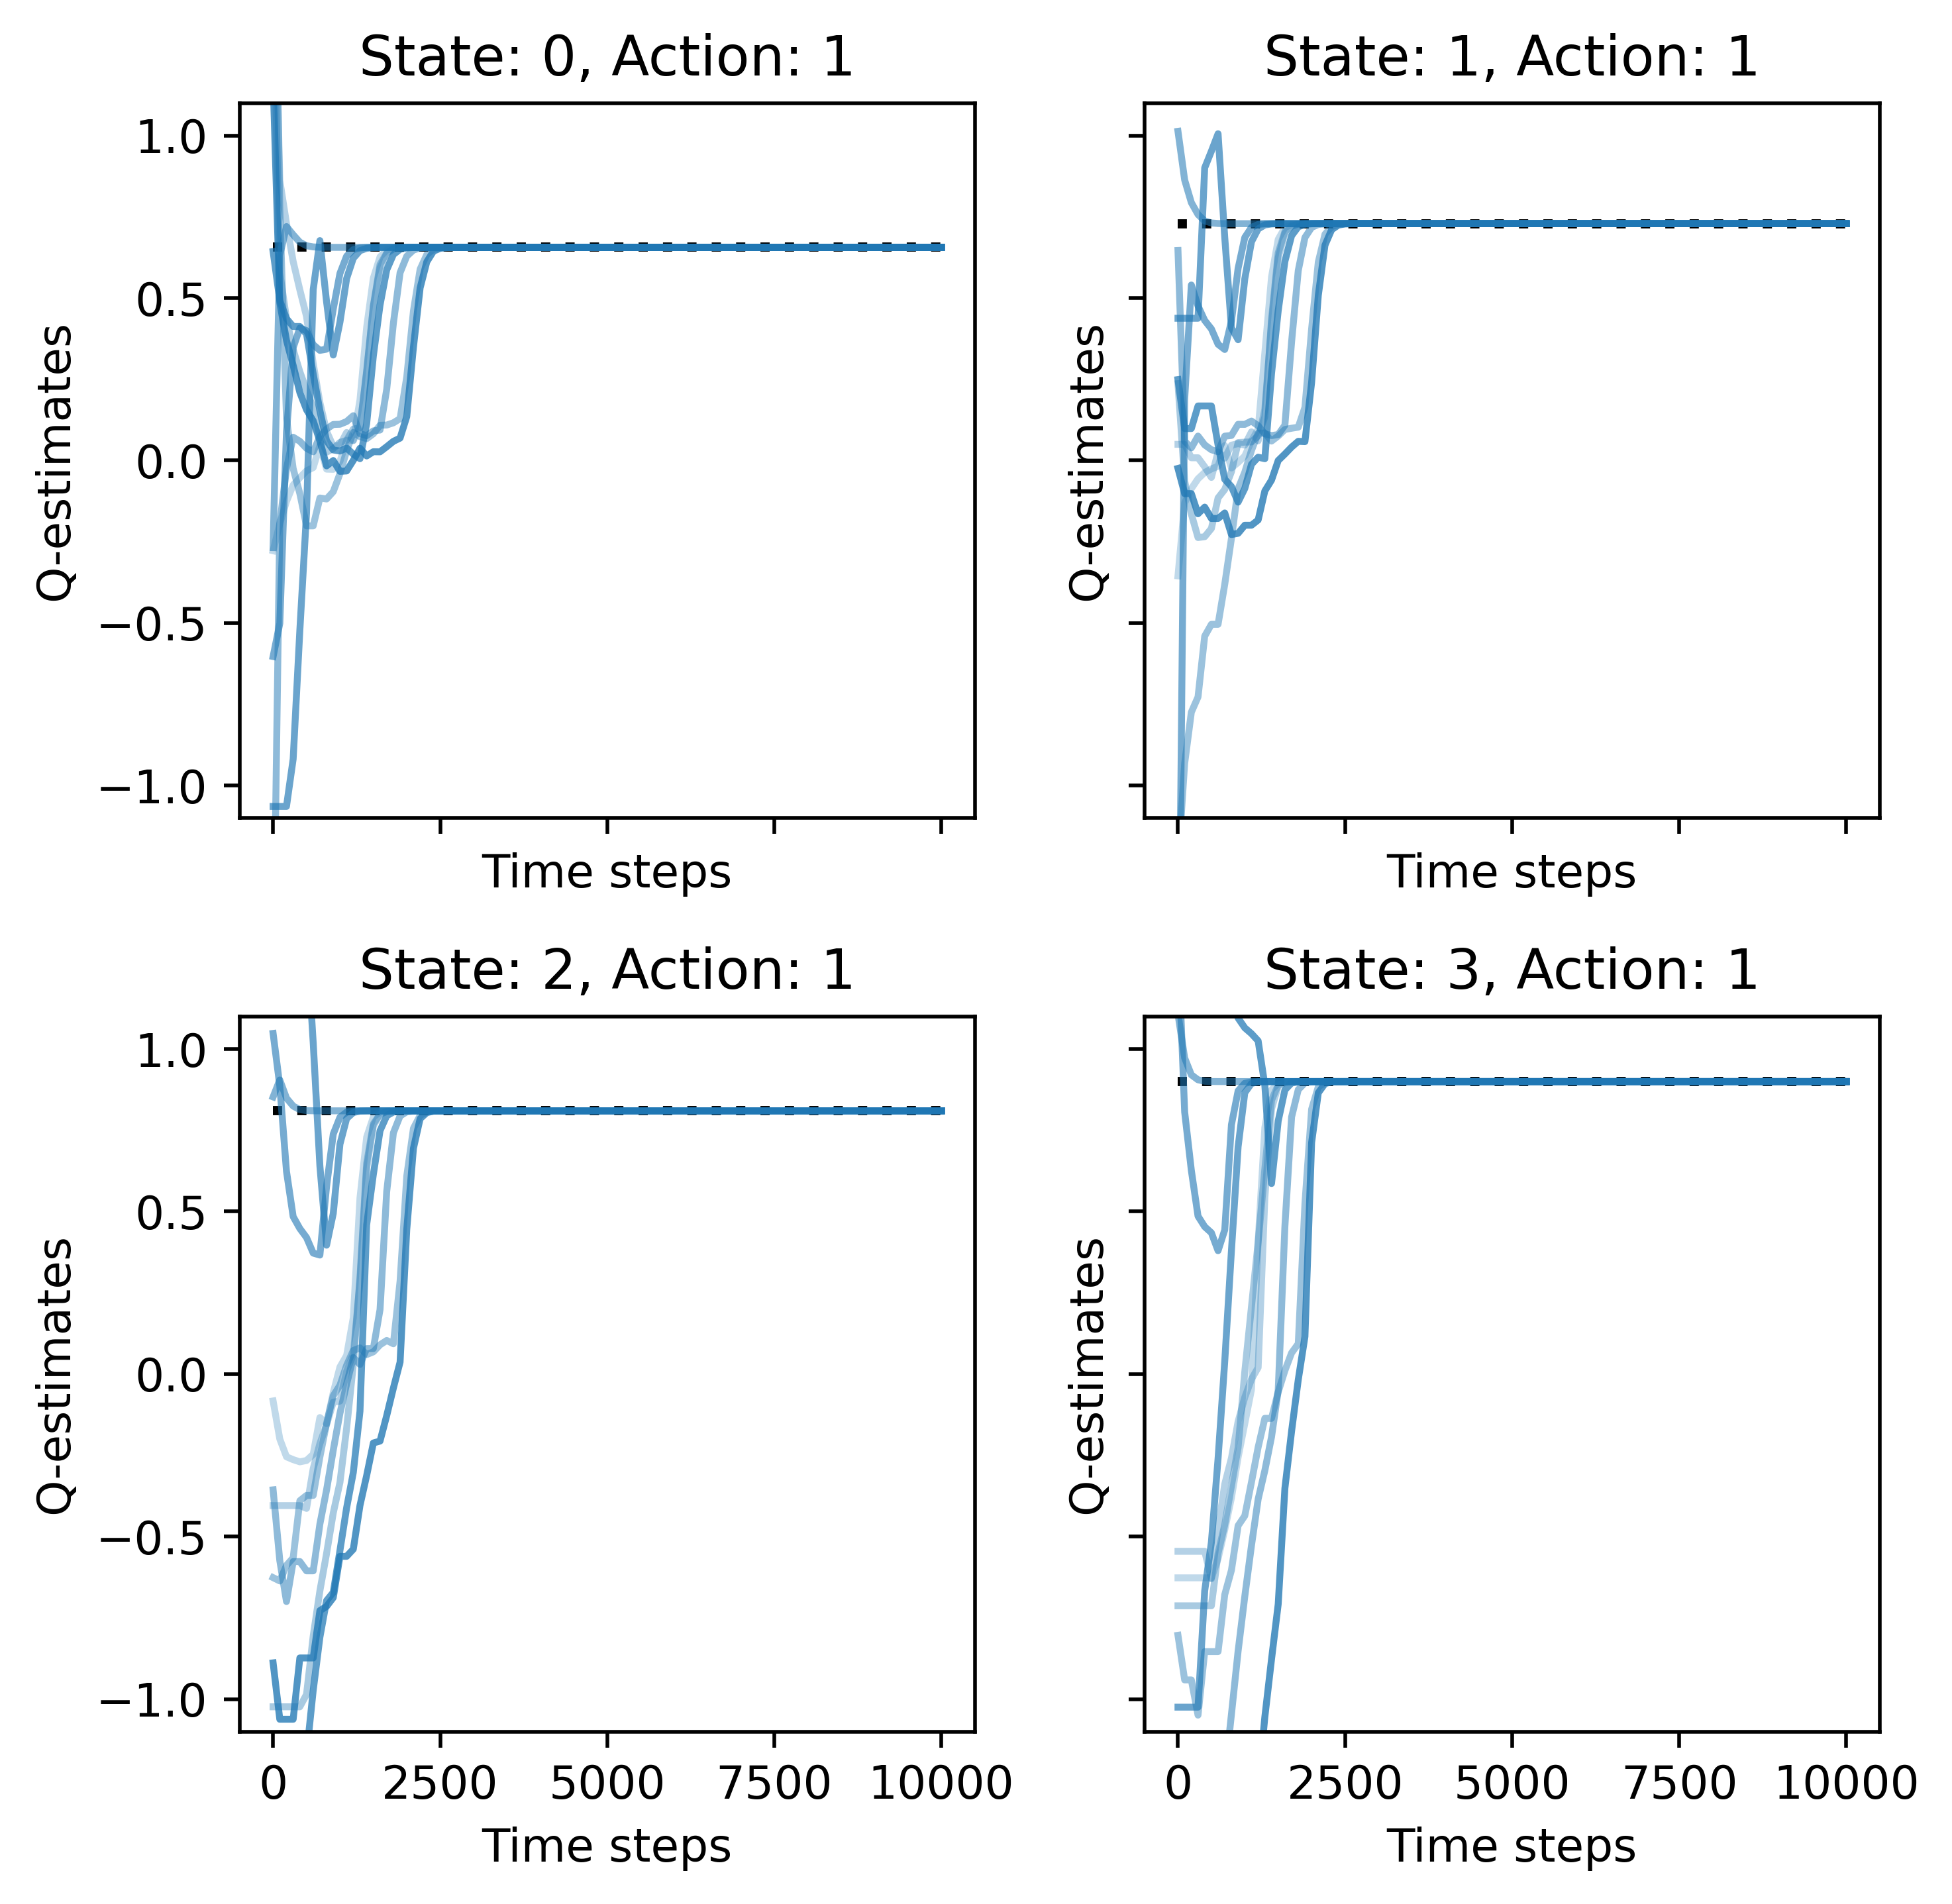

In [15]:
# Fig 9
dir_path = '../result/GridWorld/default/mu0.0/sig1.0/eps0.1/fedi100/feds1/init_p0.0/p_interval100/delta0.1/xi0.0001/p_reset0'
seed = 3
path = f'{dir_path}/seed{seed}/CAESAR'
plot_q_values_dynamic(path, display_states=range(-4,5), state_actions=[[(4,1), (5,1)], [(6,1), (7,1)]], figsize=(6, 6), legend_y=0.1, title_y=1.0, custom_title='', skip_envs=['M2'], show_legend=False)

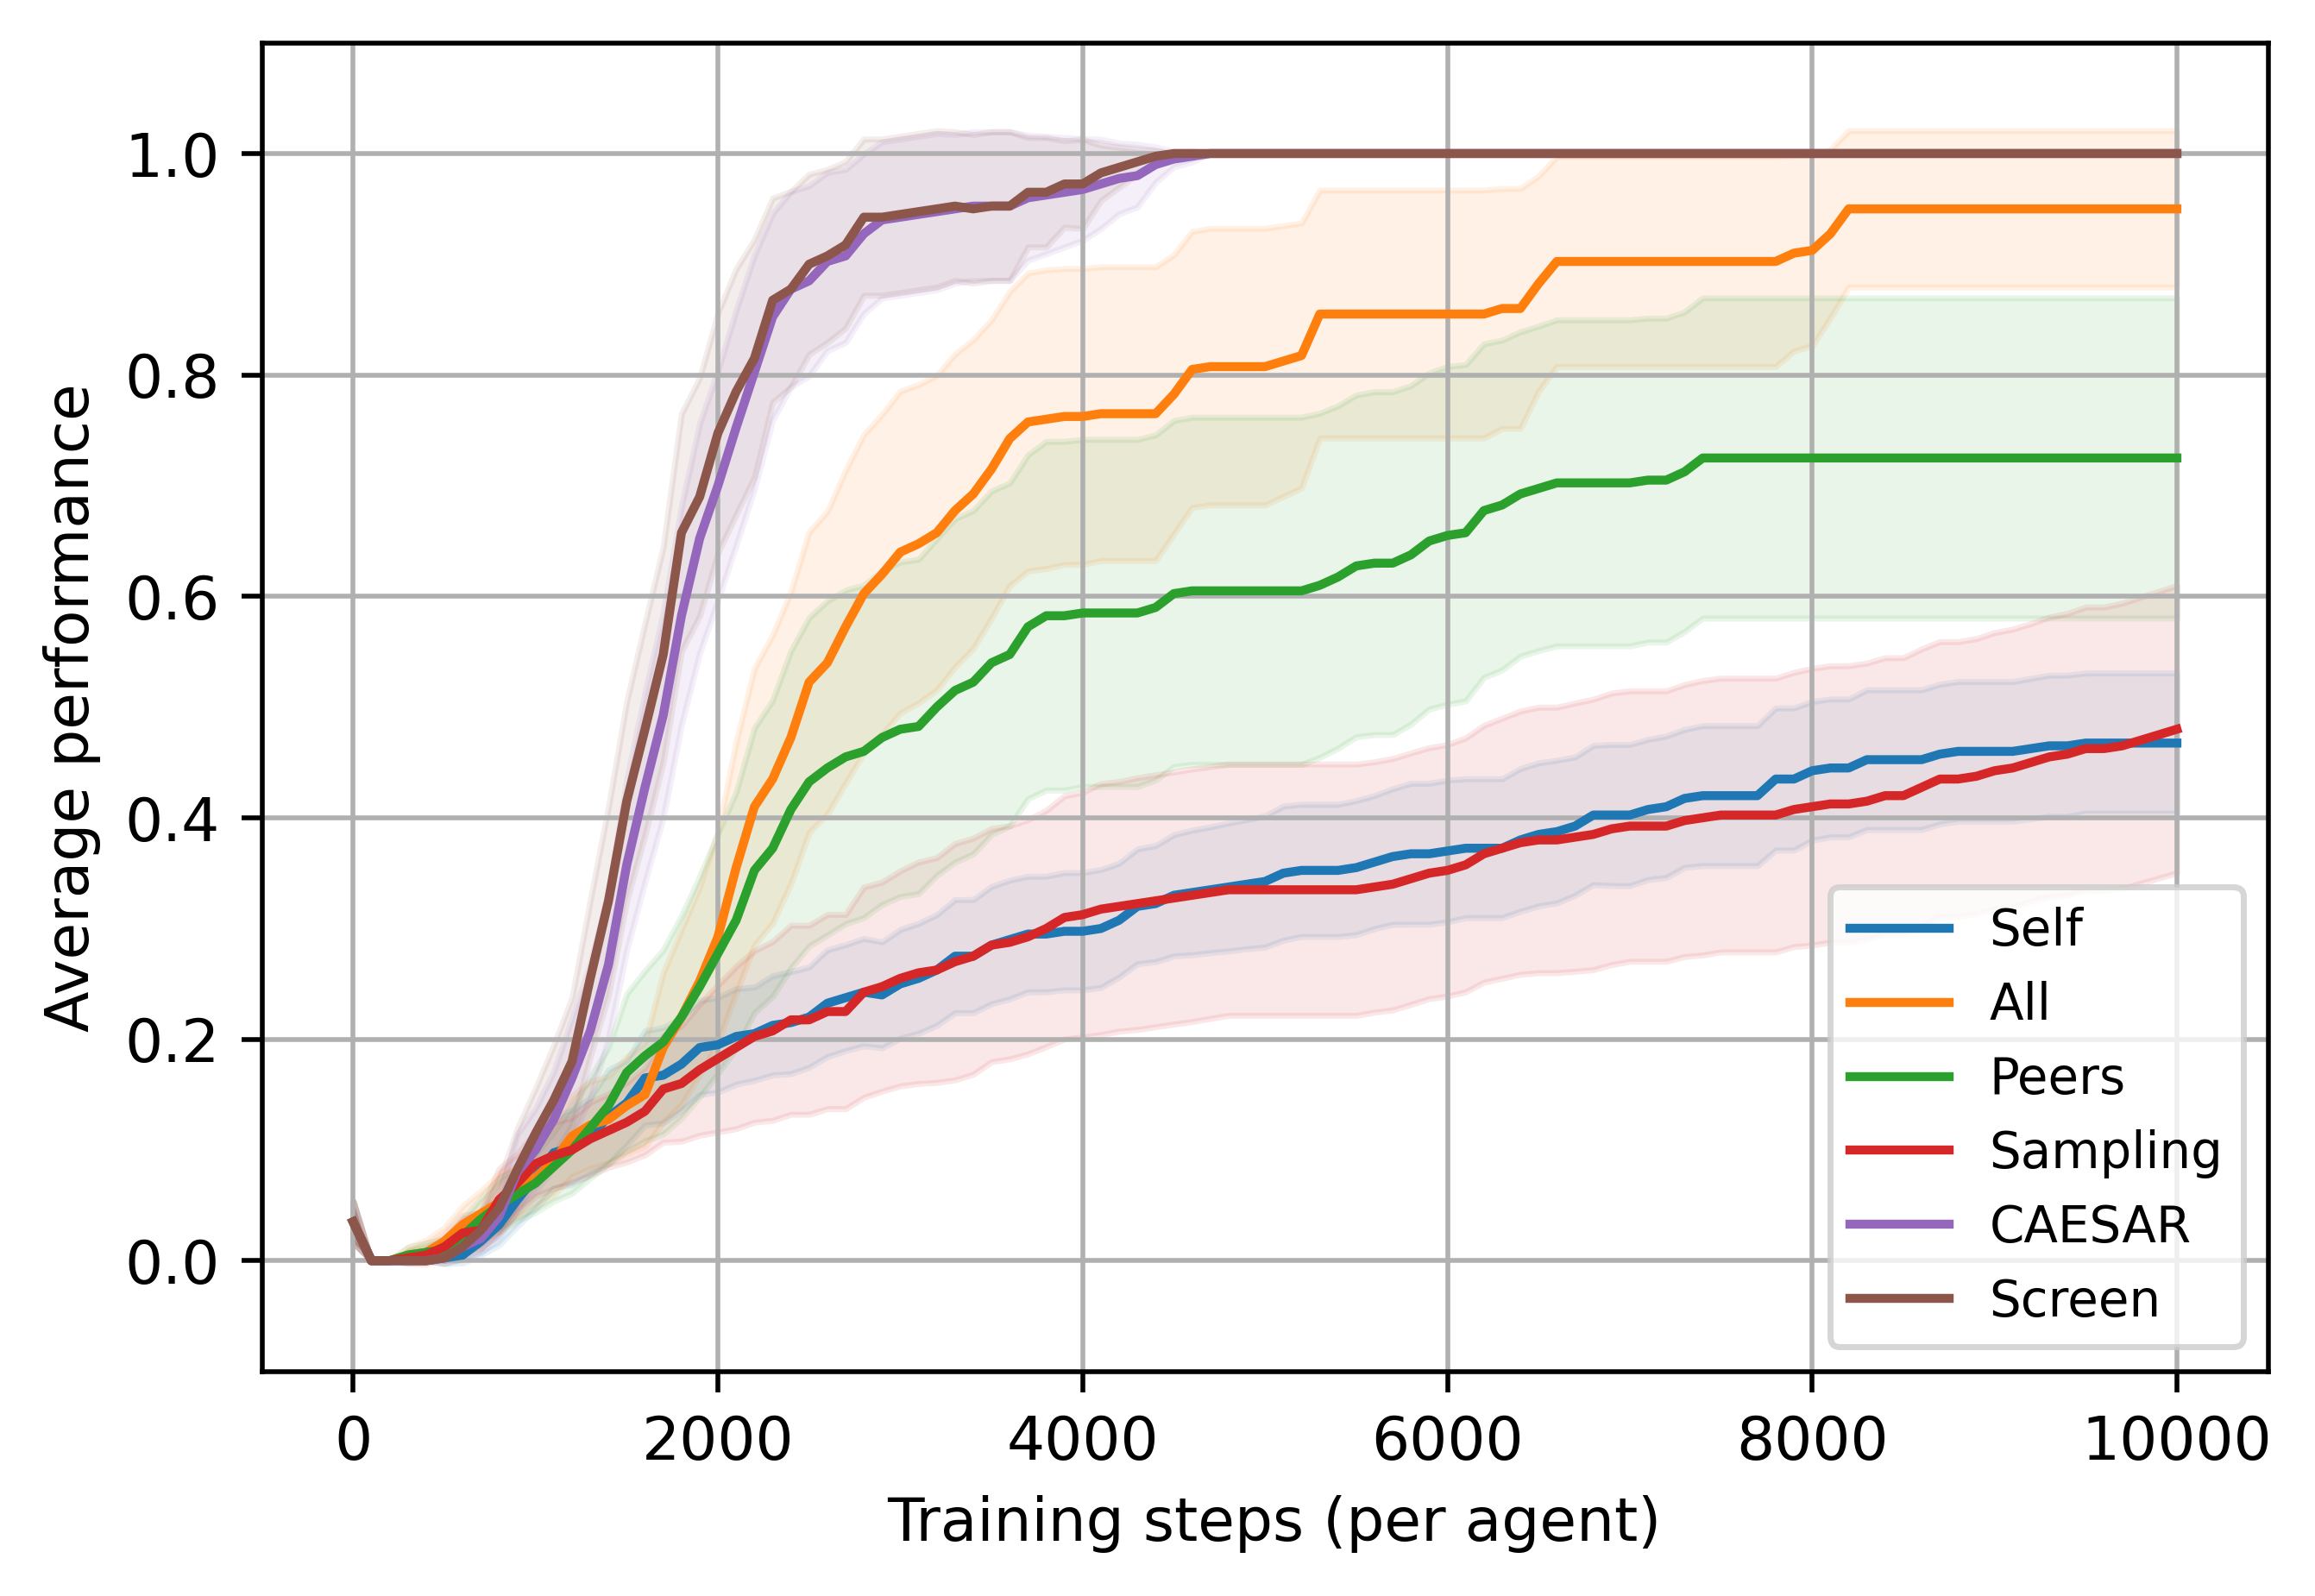

In [29]:
# Fig 10a
dir_path = '../result/FrozenLake/homogeneous/mu0.0/sig1.0/eps0.1/fedi100/feds1/init_p0.0/p_interval100/delta0.1/xi0.0001/p_reset0'
plot_eval_performance_over_seeds(dir_path, split_envs=False, std=1.0, seeds=range(20), custom_title=None, figsize=(6,4)) # 'Homogeneous Environments')

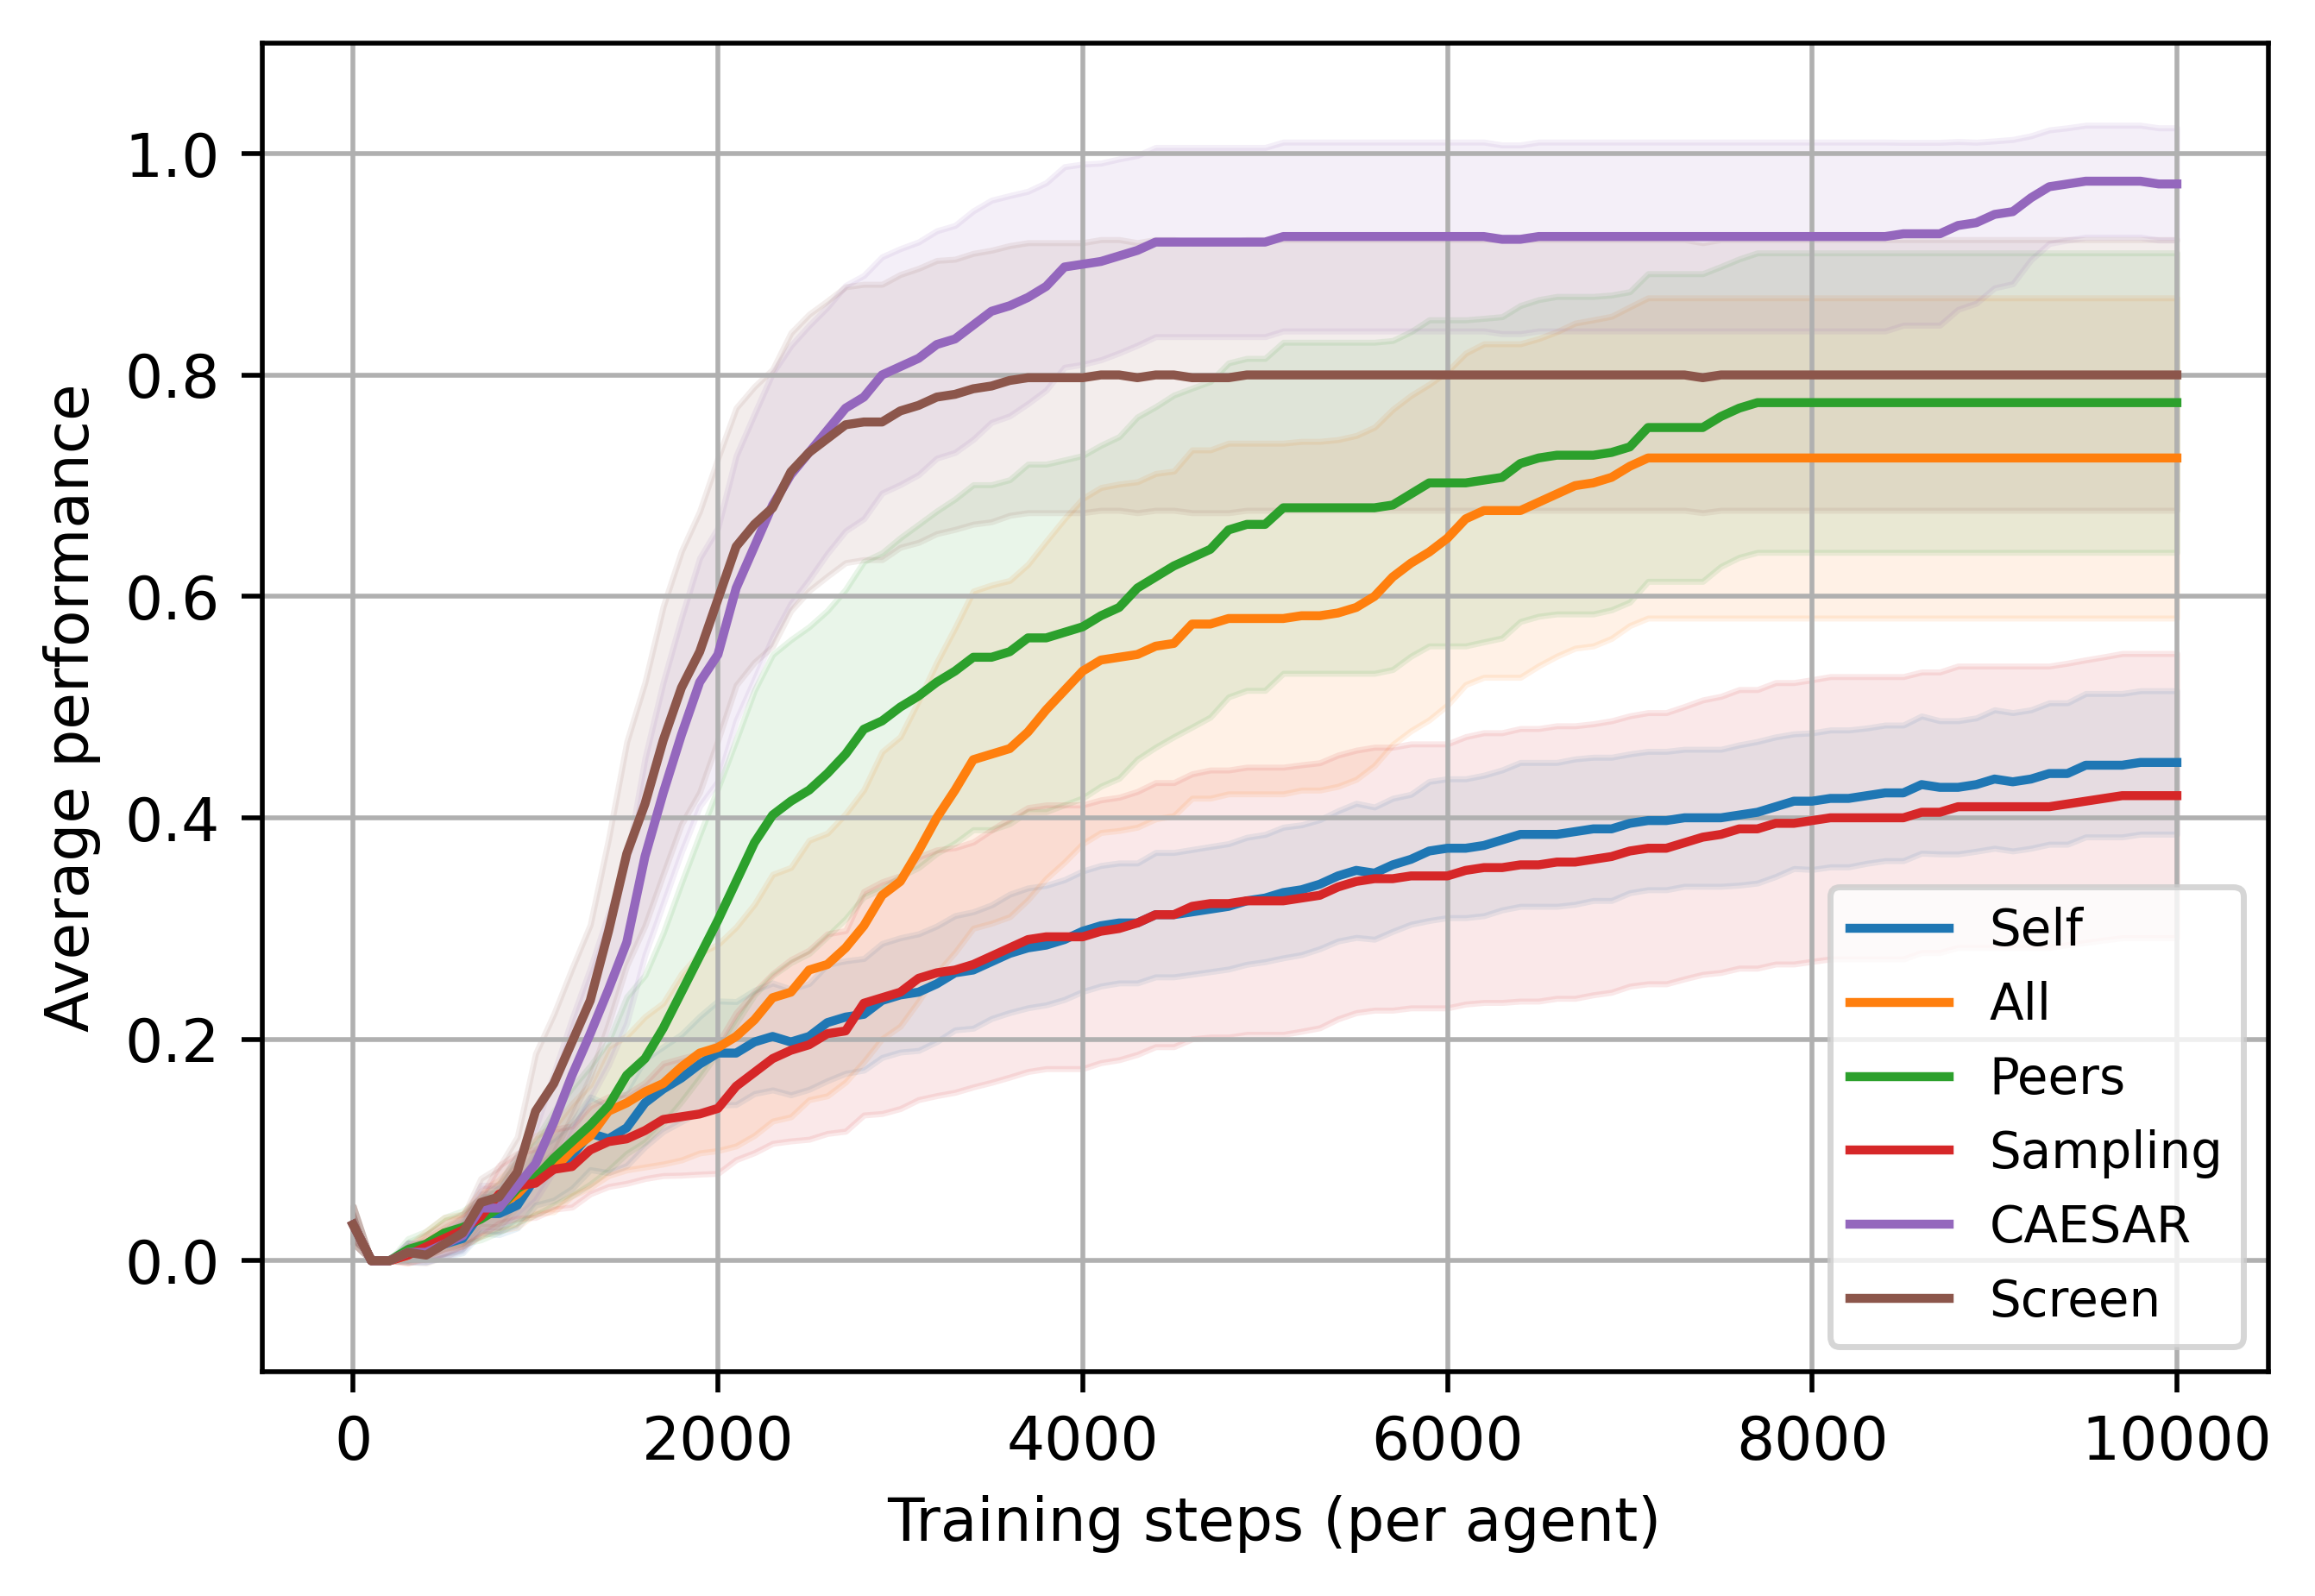

In [31]:
# Fig 10b
dir_path = '../result/FrozenLake/randomly_heterogeneous/mu0.0/sig1.0/eps0.1/fedi100/feds1/init_p0.0/p_interval100/delta0.1/xi0.0001/p_reset0'
plot_eval_performance_over_seeds(dir_path, split_envs=False, std=1.0, seeds=range(20), custom_title=None, figsize=(6,4)) # 'Mildly Heterogeneous Environments')

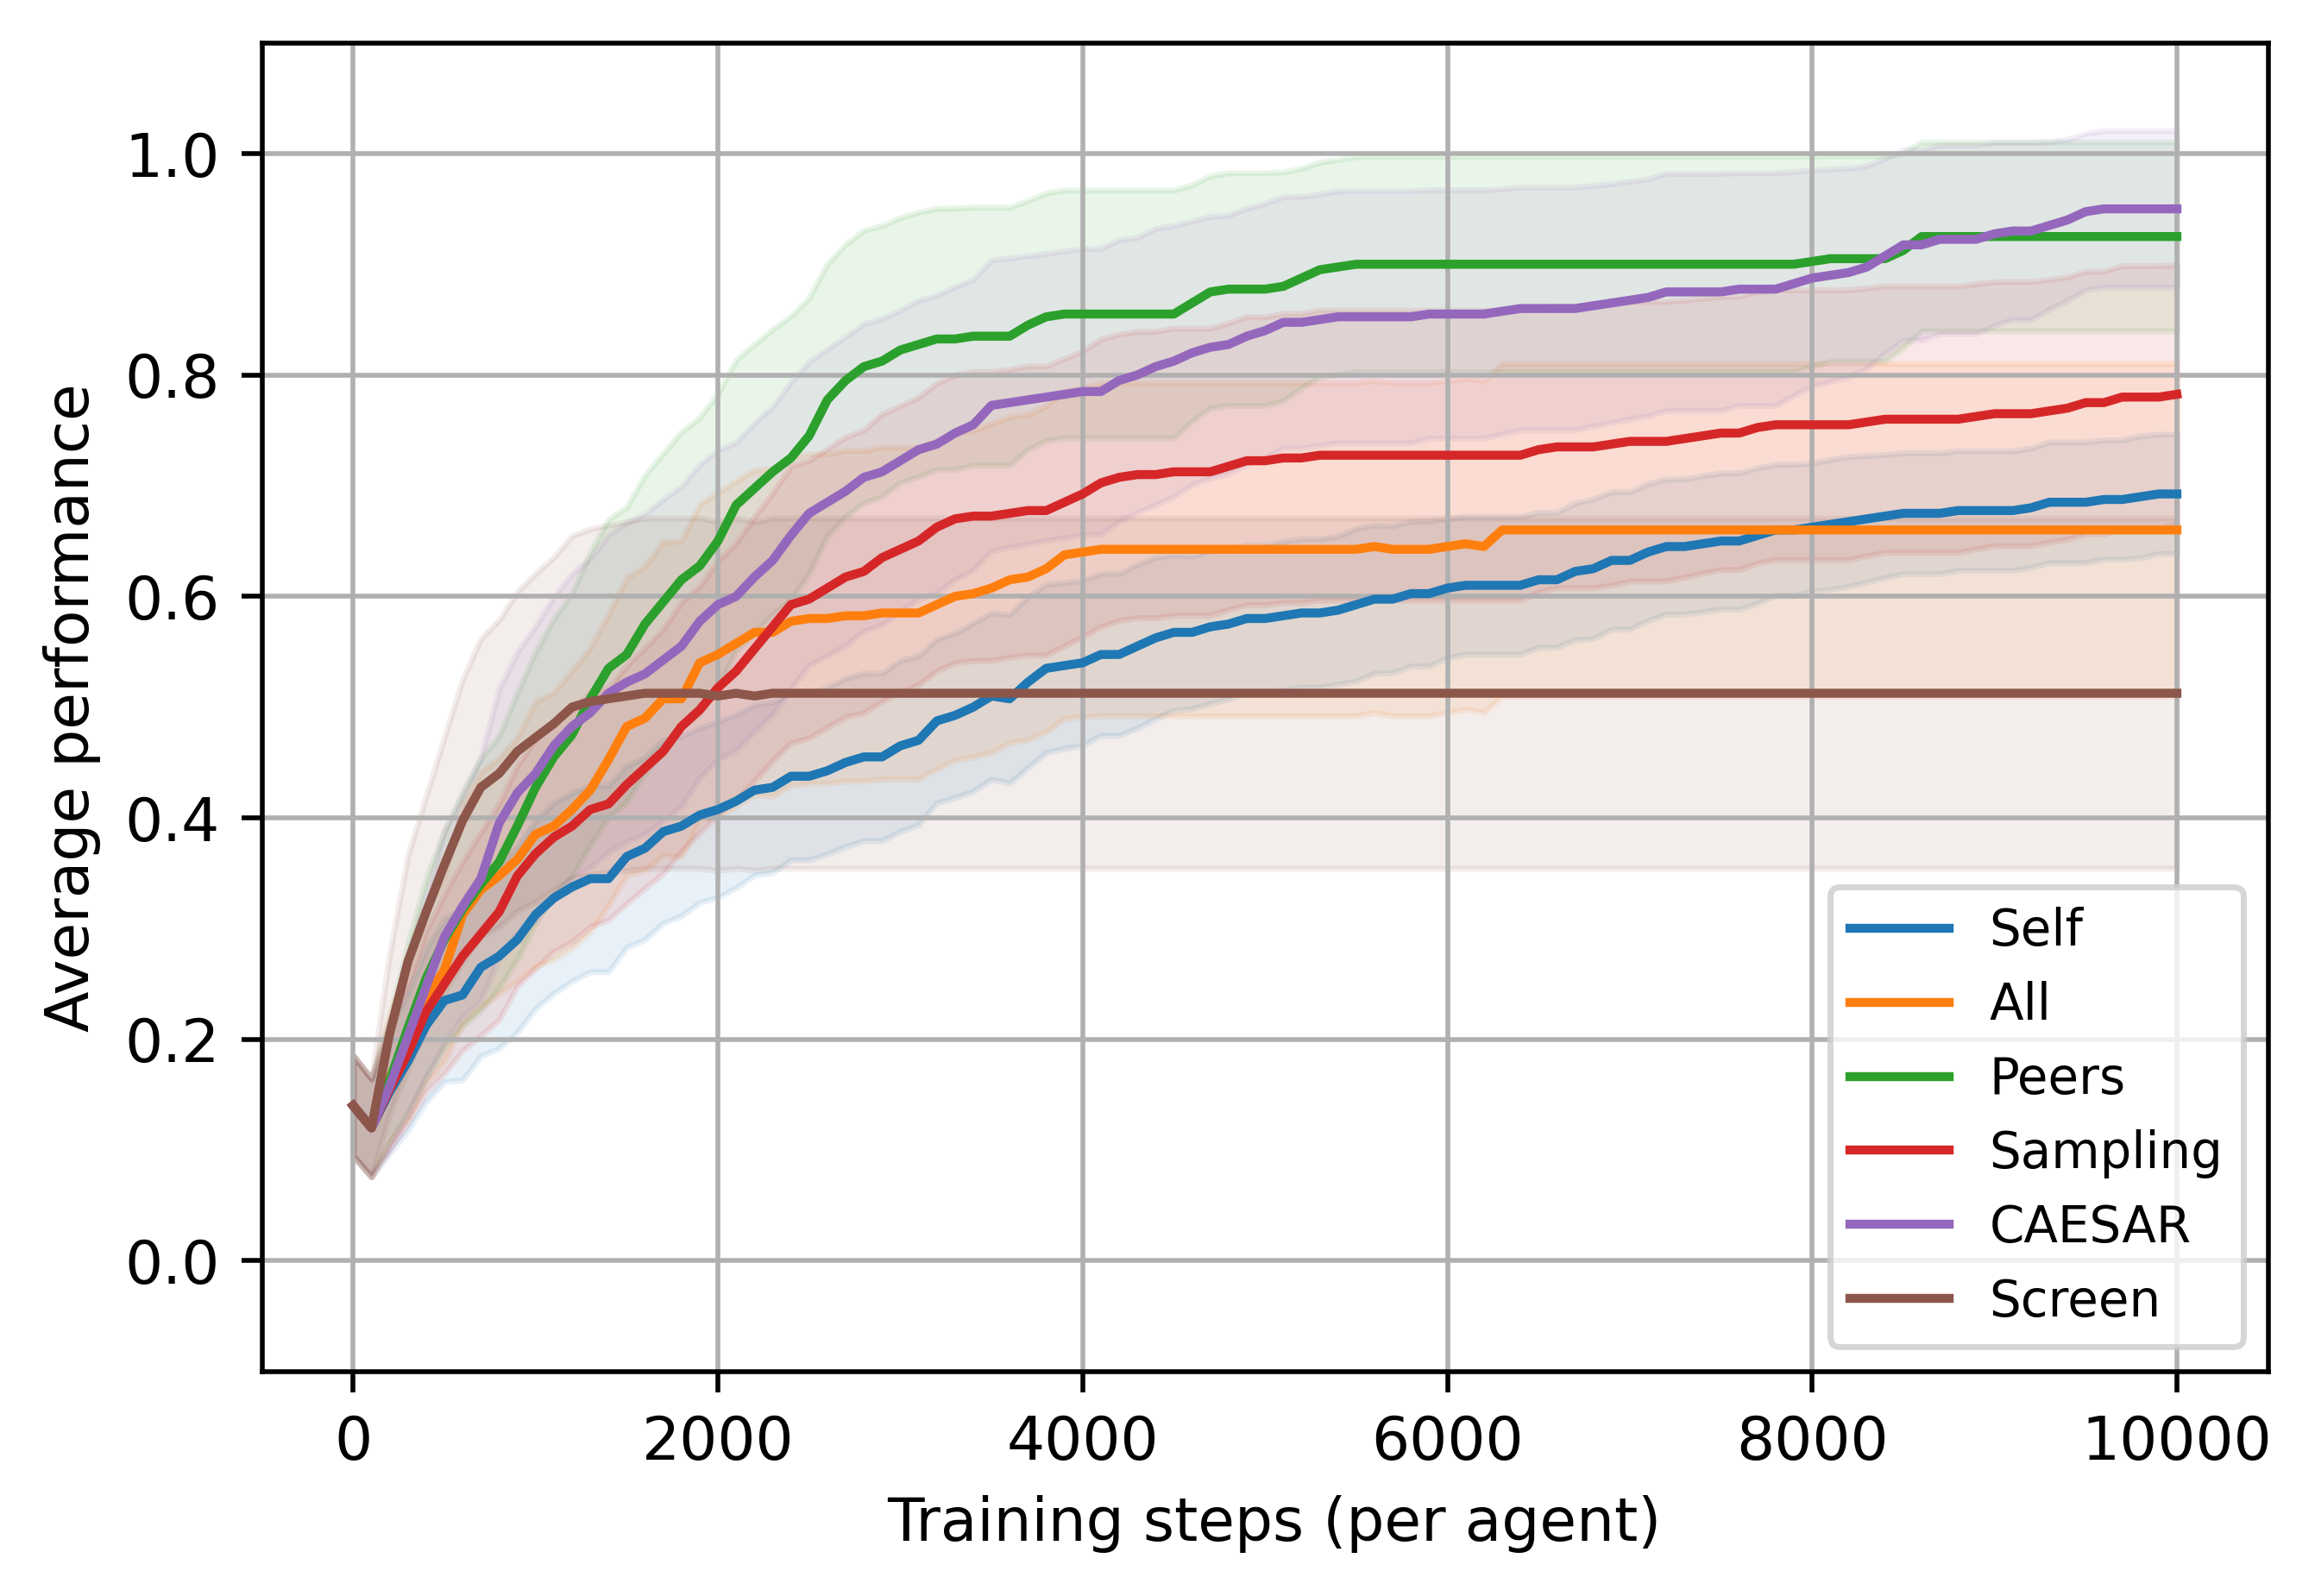

In [32]:
# Fig 10c
dir_path = '../result/FrozenLake/strongly_heterogeneous/mu0.0/sig1.0/eps0.1/fedi100/feds1/init_p0.0/p_interval100/delta0.1/xi0.0001/p_reset0'
plot_eval_performance_over_seeds(dir_path, split_envs=False, std=1.0, seeds=range(20), custom_title=None, figsize=(6,4)) # 'Mildly Heterogeneous Environments')